In [1]:
!ls /mnt/data/Train/

Alpha  Composition_code.py  FG	training_bg_names.txt  training_fg_names.txt


In [2]:
#!pip3 install scipy

In [3]:
import torch
from src.models.modnet import MODNet
from src.trainer import supervised_training_iter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import cv2
from skimage import morphology
from scipy.ndimage import distance_transform_edt
import torch.nn.functional as F



In [4]:
from pathlib import Path
import pandas as pd

# Set the base path for the dataset
base_path = Path("/mnt/data/Train/")

# Correcting the approach to construct the DataFrame without using 'append' in a loop

# Re-list the FG and Alpha images in case there was an issue with the initial listing
fg_images = list((base_path / "FG").rglob("*.*"))
alpha_images = list((base_path / "Alpha").rglob("*.*"))

# Initialize lists for holding the matched file paths
fg_file_paths = []
alpha_file_paths = []

# Map of alpha files for quick lookup by name
alpha_files_map = {alpha_image.name: alpha_image for alpha_image in alpha_images}

# Iterate over FG images and find corresponding Alpha images by name
for fg_image_path in fg_images:
    file_name = fg_image_path.name
    if file_name in alpha_files_map:
        # If the corresponding Alpha file is found, add both paths to the lists
        fg_file_paths.append(str(fg_image_path))
        alpha_file_paths.append(str(alpha_files_map[file_name]))

# Create the DataFrame directly from the lists of file paths
df_files_corrected = pd.DataFrame({
    "FG": fg_file_paths,
    "Alpha": alpha_file_paths
})

df_files_corrected.head()



,FG,Alpha
0,/mnt/data/Train/FG/0000.png,/mnt/data/Train/Alpha/0000.png
1,/mnt/data/Train/FG/0001.png,/mnt/data/Train/Alpha/0001.png
2,/mnt/data/Train/FG/0002.png,/mnt/data/Train/Alpha/0002.png
3,/mnt/data/Train/FG/0003.png,/mnt/data/Train/Alpha/0003.png
4,/mnt/data/Train/FG/0004.png,/mnt/data/Train/Alpha/0004.png


In [5]:
class ModNetDataLoader(Dataset):
    def __init__(self, annotations_file, resize_dim, transform=None):
        self.img_labels =annotations_file
        self.transform=transform
        self.resize_dim=resize_dim

    def __len__(self):
        #return the total number of images
        return len(self.img_labels)

    def __getitem__(self, idx):
        #print(idx)
        img_path = self.img_labels.iloc[idx,0]
        mask_path = self.img_labels.iloc[idx,1]
        #print(img_path,mask_path)
        temp_image = Image.open(img_path)
        #temp_image.show()
        img = np.asarray(temp_image)
        #display(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        #stupid = Image.open(mask_path)
        #stupid.show()
        #print(img.shape)
        #print(in_image.shape)
        #mask = in_image[:,:,3]
        

        if len(img.shape)==2:
            img = img[:,:,None]
        if img.shape[2]==1:
            img = np.repeat(img, 3, axis=2)
        elif img.shape[2]==4:
            img = img[:,:,0:3]

        if len(mask.shape)==3:
            mask = mask[:,:, 0]

        #convert Image to pytorch tensor
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)
        if self.transform:
            img = self.transform(img)
            trimap = self.get_trimap(mask)
            mask = self.transform(mask)

        img = self._resize(img)
        mask = self._resize(mask)
        trimap = self._resize(trimap, trimap=True)

        img = torch.squeeze(img, 0)
        mask = torch.squeeze(mask, 0)
        trimap = torch.squeeze(trimap, 1)
        #print(img.shape,trimap.shape,mask.shape)
        return img.cuda(), trimap.cuda(), mask.cuda()

    def get_trimap(self, alpha):
        # alpha \in [0, 1] should be taken into account
        # be careful when dealing with regions of alpha=0 and alpha=1
        fg = np.array(np.equal(alpha, 255).astype(np.float32))
        unknown = np.array(np.not_equal(alpha, 0).astype(np.float32)) # unknown = alpha > 0
        unknown = unknown - fg
        # image dilation implemented by Euclidean distance transform
        unknown = distance_transform_edt(unknown==0) <= np.random.randint(1, 20)
        trimap = fg
        trimap[unknown] = 0.5
        return torch.unsqueeze(torch.from_numpy(trimap), dim=0)#.astype(np.uint8)

    def _resize(self, img, trimap=False):
        im = img[None, :, :, :]
        ref_size = self.resize_dim

        # resize image for input
        im_b, im_c, im_h, im_w = im.shape
        if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
            if im_w >= im_h:
                im_rh = ref_size
                im_rw = int(im_w / im_h * ref_size)
            elif im_w < im_h:
                im_rw = ref_size
                im_rh = int(im_h / im_w * ref_size)
        else:
            im_rh = im_h
            im_rw = im_w

        im_rw = im_rw - im_rw % 32
        im_rh = im_rh - im_rh % 32
        im_rw=512
        im_rh=512
        if trimap == True:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='nearest')
        else:
            im = F.interpolate(im, size=(im_rh, im_rw), mode='area')
        #imb =transforms.ToPILImage()(im.squeeze().cpu())
        #imb.show()
        return im

In [6]:
#train_data = ModNetDataLoader(df_files_corrected,1080,True)
transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)
            )
        ]
    )
data = ModNetDataLoader(df_files_corrected, 512, transform=transformer)

In [7]:
import matplotlib
print(matplotlib.get_backend())
# If necessary, switch to an interactive backend, e.g., 'TkAgg', 'Qt5Agg'
# matplotlib.use('TkAgg')


module://matplotlib_inline.backend_inline


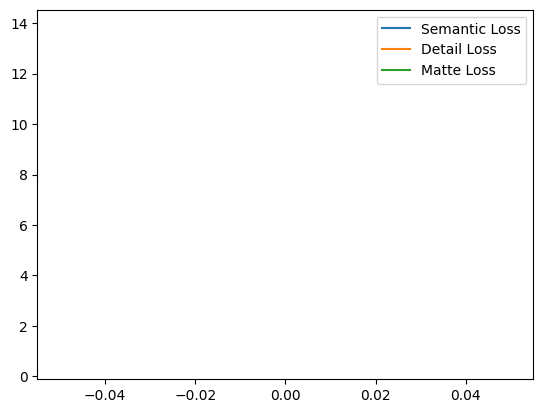

<Figure size 640x480 with 0 Axes>

In [ ]:
bs = 16         # batch size
lr = 0.01       # learn rate
epochs = 40     # total epochs
train_dataloader = DataLoader(data, batch_size=8, shuffle=True)
modnet = torch.nn.DataParallel(MODNet()).cuda()
optimizer = torch.optim.SGD(modnet.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(0.25 * epochs), gamma=0.1)

#dataloader = train-datalo(bs)     # NOTE: please finish this function

#for epoch in range(0, epochs):
#    for idx, (image, trimap, gt_matte) in enumerate(train_dataloader):
#        semantic_loss, detail_loss, matte_loss = \
#            supervised_training_iter(modnet, optimizer, image, trimap, gt_matte)
#        lr_scheduler.step()

import matplotlib.pyplot as plt

# Initialize lists to store loss values
semantic_losses, detail_losses, matte_losses = [], [], []

plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Over Time')

update_freq = 100  # Update the plot every 100 iterations
for epoch in range(0, epochs):
    for idx, (image, trimap, gt_matte) in enumerate(train_dataloader):
        # Your training step
        semantic_loss, detail_loss, matte_loss = supervised_training_iter(modnet, optimizer, image, trimap, gt_matte)
        
        semantic_losses.append(semantic_loss.item())
        detail_losses.append(detail_loss.item())
        matte_losses.append(matte_loss.item())

        if idx % update_freq == 0:
            # Efficiently update the plot
            ax.clear()
            if len(semantic_losses) > 0:
                ax.plot(semantic_losses, label='Semantic Loss')
            if len(detail_losses) > 0:
                ax.plot(detail_losses, label='Detail Loss')
            if len(matte_losses) > 0:
                ax.plot(matte_losses, label='Matte Loss')
            
            ax.legend()
            plt.draw()
            plt.pause(0.1)  # A slightly longer pause to ensure the GUI has time to update

    lr_scheduler.step()

plt.ioff()  # Turn off interactive mode when done to finalize the plot



In [ ]:
import numpy as np
import os
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images
#image_names = os.listdir(input_folder)
#for image_name in image_names:
  #matte_name = image_name.split('.')[0] + '.png'
  #image = Image.open(os.path.join(input_folder, image_name))
  #matte = Image.open(os.path.join(output_folder, matte_name))
  #display(combined_display(image, matte))
  #print(image_name, '\n')

In [ ]:
a,b,c=modnet(data[1][0].unsqueeze(0).cuda(),False)

In [ ]:
print(a.shape,c.shape)
origin=transforms.ToPILImage()(data[1][0].squeeze().cuda())
cc=transforms.ToPILImage()(c.squeeze().cuda())
print("hi")
combined_display(origin,cc)
#imb =transforms.ToPILImage()(im.squeeze().cpu())